In [5]:
!git config --global user.email "shellyser@campus.technion.ac.il"
!git config --global user.name "shelly-serafimovich"
!git clone https://github.com/shelly-serafimovich/lol.git


Cloning into 'lol'...


import the data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/posts_csv (1).csv')
df = df.dropna(subset=['text'])

# Filter rows where the 'text' column has less than 4 words
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df = df[df['word_count'] >= 4].drop('word_count', axis=1)
df['text'] = df['text'].str.lower().str.strip()
df.shape[0]

491

drop the irrelevant posts


In [ ]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7969f8010f7035d17c5eb187a96093e0bff3cc731e82d11783a5408e3ab3d515
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from transformers import pipeline
import pandas as pd


# Step 2: Initialize Spark Session
spark = SparkSession.builder \
    .appName("ZeroShotClassification") \
    .getOrCreate()

# Step 3: Create a Spark DataFrame from pandas DataFrame
sdf = spark.createDataFrame(df)

# UDF Wrapper for Zero-Shot Classification
class ZeroShotClassifierWrapper:
    model = None

    @classmethod
    def get_model(cls):
        if cls.model is None:
            cls.model = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
        return cls.model

# Define the UDF
@udf(returnType=StringType())
def classify_text(text):
    classifier = ZeroShotClassifierWrapper.get_model()
    result = classifier(text, ["Job Announcement", "Other Topics"])
    # Assuming the first label is the target prediction
    prediction = result['labels'][0]
    return prediction

# Step 4: Apply the classification UDF to the DataFrame
sdf = sdf.withColumn("prediction", classify_text(sdf["text"]))

# Step 5: Collect Results
# Be cautious with collect() on large datasets, as it pulls the data into the driver's memory
result_pdf = sdf.toPandas()

# Display the results
print(result_pdf)

     Unnamed: 0                        id  \
0             0  caressa-grooms-4b0477224   
1             1  caressa-grooms-4b0477224   
2             2  caressa-grooms-4b0477224   
3             3  caressa-grooms-4b0477224   
4             4  caressa-grooms-4b0477224   
..          ...                       ...   
517         630          christopherirish   
518         631          christopherirish   
519         632          christopherirish   
520         633          keri-w-62167b14a   
521         634          keri-w-62167b14a   

                                              headline       geoLocationName  \
0    Operations Data Analyst at Island Mountain Dev...     Billings, Montana   
1    Operations Data Analyst at Island Mountain Dev...     Billings, Montana   
2    Operations Data Analyst at Island Mountain Dev...     Billings, Montana   
3    Operations Data Analyst at Island Mountain Dev...     Billings, Montana   
4    Operations Data Analyst at Island Mountain Dev...     

In [ ]:
result_pdf

In [ ]:
result_pdf.to_csv('result_pdf.csv', index=False)
df = result_pdf[result_pdf['prediction'] == 'Other Topics']
df.shape[0]

330

In [ ]:
# Define the phrase to check for
phrase_to_check = ["I'm happy to share that I'm starting a new position as"]

# Ensure we work with strings only and drop NaN values to avoid errors
df = df.dropna(subset=['text'])

# Convert the 'text' column to lowercase and remove leading/trailing whitespace
df['text'] = df['text'].str.lower().str.strip()

for phrase in phrase_to_check:
  filtered_df = df[~df['text'].str.startswith(phrase.lower().strip())]

num_rows_after_adjusted = filtered_df.shape[0]
num_rows_after_adjusted

330

distribution of likes, shares, and comments

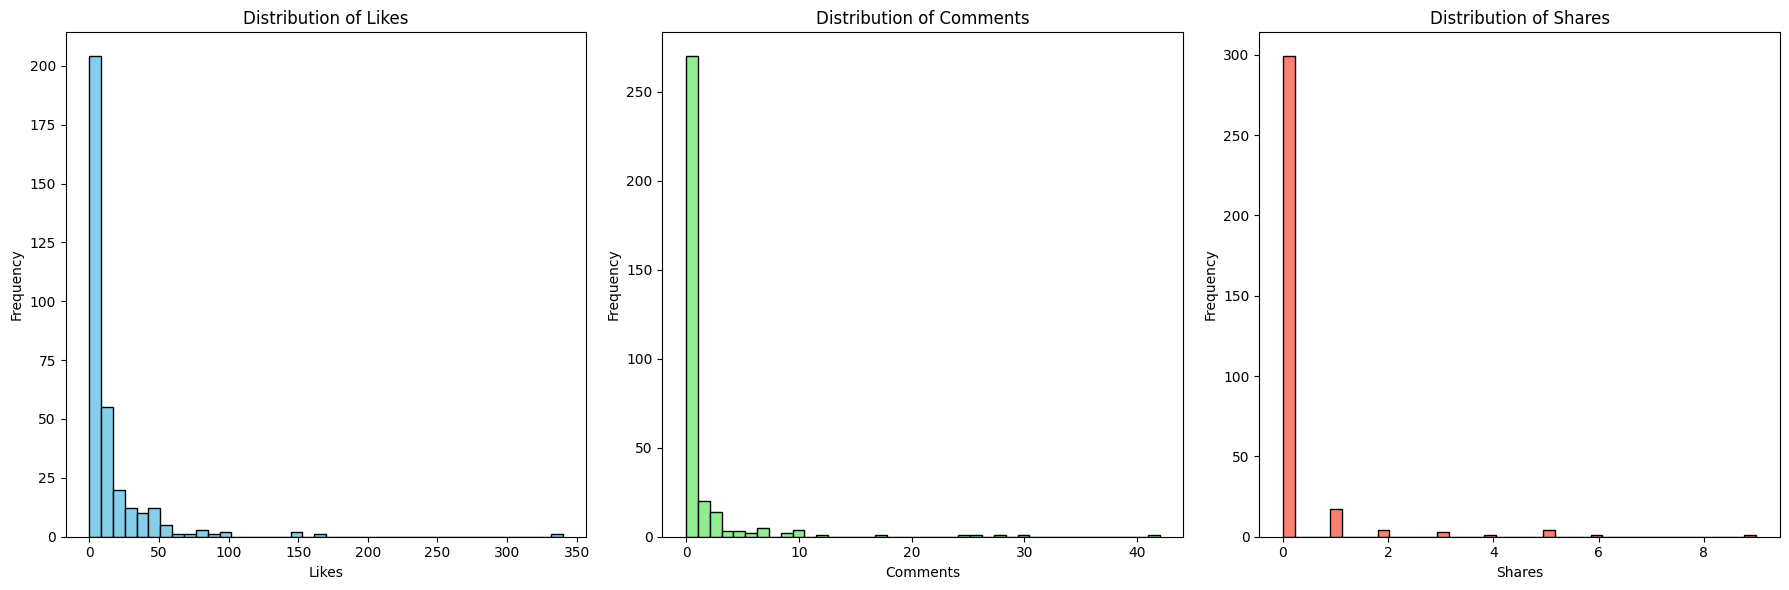

             likes   comments    shares
max     340.000000  42.000000  9.000000
min       0.000000   0.000000  0.000000
mean     13.987879   1.312121  0.221212
median    5.000000   0.000000  0.000000


In [ ]:
# Plotting the distribution of likes, shares, and comments
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Likes
axes[0].hist(df['likes'], bins=40, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Likes')
axes[0].set_xlabel('Likes')
axes[0].set_ylabel('Frequency')

# Comments
axes[1].hist(df['comments'], bins=40, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribution of Comments')
axes[1].set_xlabel('Comments')
axes[1].set_ylabel('Frequency')

# Shares
axes[2].hist(df['shares'], bins=40, color='salmon', edgecolor='black')
axes[2].set_title('Distribution of Shares')
axes[2].set_xlabel('Shares')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate and print the max, min, mean, and median for likes, shares, and comments
metrics = pd.DataFrame(index=['max', 'min', 'mean', 'median'])

metrics['likes'] = [df['likes'].max(), df['likes'].min(), df['likes'].mean(), df['likes'].median()]
metrics['comments'] = [df['comments'].max(), df['comments'].min(), df['comments'].mean(), df['comments'].median()]
metrics['shares'] = [df['shares'].max(), df['shares'].min(), df['shares'].mean(), df['shares'].median()]

print(metrics)


decision rule

In [ ]:
import pandas as pd
import numpy as np


#decision rule
df['popularity_score'] = ((df['likes'] * 1) + (df['comments'] * 3) + (df['shares'] * 9)) / (np.log(df['followers'] + 1) + 1)
#normalize between 0-1
df['popularity_score'] = df['popularity_score'].astype(int)
df['popularity_score'] = (df['popularity_score'] - df['popularity_score'].min()) / (df['popularity_score'].max() - df['popularity_score'].min())
df

,Unnamed: 0,id,headline,geoLocationName,summary,industryName,followers,connections,text,likes,comments,shares,number_of_images,prediction,popularity_score
0,0,caressa-grooms-4b0477224,Operations Data Analyst at Island Mountain Dev...,"Billings, Montana",NaN,Financial Services,28,27,just finished the course “mel robbins on confi...,0,0,0,0,Other Topics,0.000000
1,1,caressa-grooms-4b0477224,Operations Data Analyst at Island Mountain Dev...,"Billings, Montana",NaN,Financial Services,28,27,just finished the course “building resilience”...,0,0,0,0,Other Topics,0.000000
2,2,caressa-grooms-4b0477224,Operations Data Analyst at Island Mountain Dev...,"Billings, Montana",NaN,Financial Services,28,27,just finished the course “getting things done”...,0,0,0,0,Other Topics,0.000000
4,4,caressa-grooms-4b0477224,Operations Data Analyst at Island Mountain Dev...,"Billings, Montana",NaN,Financial Services,28,27,just finished the course “the six morning habi...,0,0,0,0,Other Topics,0.000000
7,8,lavanya-bandari-b6219710,Architect | Product Strategy | Data Scientist ...,"San Francisco, California",Summary:\n\nCurrently architecting Solutions i...,Information Technology & Services,641,500,best captured our west sa team in one frame!,73,1,0,1,Other Topics,0.196078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,627,jensen-masuda,Girl Dad|Data|High-Growth|Passion,"Nashville, Tennessee","I spend my time building incredible teams, def...",Logistics & Supply Chain,1311,500,five years at amazon -- in grad school puneet ...,340,28,0,1,Other Topics,1.000000
515,628,christopherirish,Senior Enterprise Account Executive at MongoDB,"Seattle, Washington","Strategic sales manager, entrepreneur, and act...",Computer Software,5000,500,retool state of ai survey took the pulse of ov...,4,0,0,0,Other Topics,0.000000
517,630,christopherirish,Senior Enterprise Account Executive at MongoDB,"Seattle, Washington","Strategic sales manager, entrepreneur, and act...",Computer Software,5000,500,atlas vector search accelerates your journey t...,8,0,0,0,Other Topics,0.000000
518,631,christopherirish,Senior Enterprise Account Executive at MongoDB,"Seattle, Washington","Strategic sales manager, entrepreneur, and act...",Computer Software,5000,500,mongodb doubles profit expectations and oblite...,35,1,0,0,Other Topics,0.058824


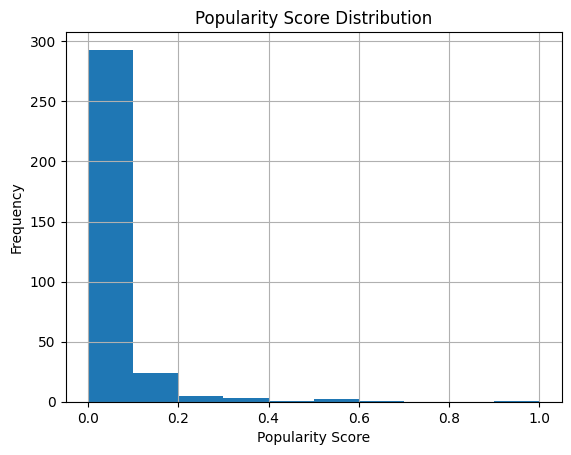

In [ ]:
import matplotlib.pyplot as plt

df['popularity_score'].hist()
plt.title('Popularity Score Distribution')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency')

plt.show()

normalization

In [ ]:
# Calculate the mean and standard deviation
mean_popularity = df['popularity_score'].mean()
std_dev_popularity = df['popularity_score'].std()

# Calculate the threshold
threshold = mean_popularity + std_dev_popularity

values_above_threshold = (df['popularity_score'] > threshold).sum()
values_above_threshold

27

In [ ]:
threshold

0.14122348166221557

In [ ]:
filtered_df = df[df['popularity_score'] > threshold]
filtered_df.to_csv('text_column.csv', index=False)